In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table
from astropy.io import fits

from ekfplot import plot as ek

from agrias import utils
import reader

In [8]:
merian = table.Table(fits.getdata('/Users/kadofong/Downloads/Merian_DR1_photoz_EAZY_v1.2.fits',1))
ms = reader.merianselect ( merian )
_galex = reader.galexcrossmatch ()
overlap = ms.index.intersection(_galex.index)

merian_sources = ms.reindex(overlap)

_galex = _galex.sort_values('fuv_exptime', ascending=False)

galex = _galex.loc[~_galex.index.duplicated(keep='first')].reindex(overlap).reset_index()

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [304]:
catalog_halum = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)

In [305]:
lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0)
lha_df = lha_df.reindex(merian_sources.index)

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


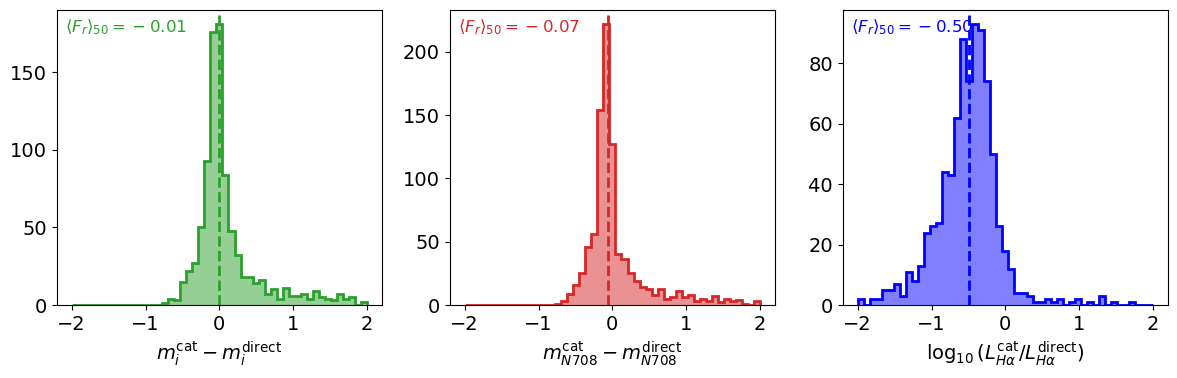

In [306]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
catalog_apercorr = merian_sources['i_cModelFlux_Merian'] / merian_sources['i_gaap1p0Flux_Merian']
f2m = lambda x, zp = 31.4: -2.5*np.log10(x*catalog_apercorr) + zp
ratios = [
    merian_sources['i_cModelmag_Merian'] - lha_df.reindex(merian_sources.index)['imag'],
    f2m(merian_sources['N708_gaap1p0Flux_Merian']) - lha_df.reindex(merian_sources.index)['n708mag'],    
    #np.log10(catalog_halum['LHa']/1e40/lha_df.reindex(catalog_halum.index)['LHa']),
    np.log10(calibrations.SFR2LHa(10.**merian_sources['logsfr_gaap1p0']) / (lha_df['LHa']*1e40) )
]
colorlist = [
    'tab:green',
    'tab:red',
    'b'
]
labels = [
    r'$m_i^{\rm cat} - m_i^{\rm direct}$',
    r'$m_{N708}^{\rm cat} - m_{N708}^{\rm direct}$',
    r'$\log_{10}(L_{H\alpha}^{\rm cat}/L_{H\alpha}^{\rm direct})$'
]

for idx, ax in enumerate(axarr):
    ek.hist( 
        ratios[idx],
        bins=np.linspace(-2.,2.,50),
        ax=axarr[idx],
        color=colorlist[idx],
        alpha=0.5,
        lw=2
    )    
    axarr[idx].axvline(
        np.nanmedian(ratios[idx]),
        color=colorlist[idx],
        lw=2,
        ls='--'
    )
    ek.text(
        0.025,
        0.975,        
        r'$\langle F_r \rangle_{50} = %.2f$' % np.nanmedian(ratios[idx]),
        ax=axarr[idx],
        color=colorlist[idx],
        fontsize=12
    )
    axarr[idx].set_xlabel(labels[idx])   
plt.tight_layout ()
plt.savefig('../../../sfr_calibrators/figures/data_validation/photometric_offsets.png')

In [204]:
from ekfphys import calibrations, observer
from ekfparse import query

In [213]:
rv = 3.1
ge_av = merian_sources['ebv_Merian']*rv

In [232]:
gecorr = np.zeros([len(ge_av),2])
for idx,row in enumerate(ge_av.values):
    gecorr[idx] = -observer.gecorrection(np.array([4758.71,6135.]), row, return_magcorr=True)


In [286]:
ref = np.genfromtxt('/Users/kadofong/Desktop/ref.txt')

Text(0, 0.5, 'g-r')

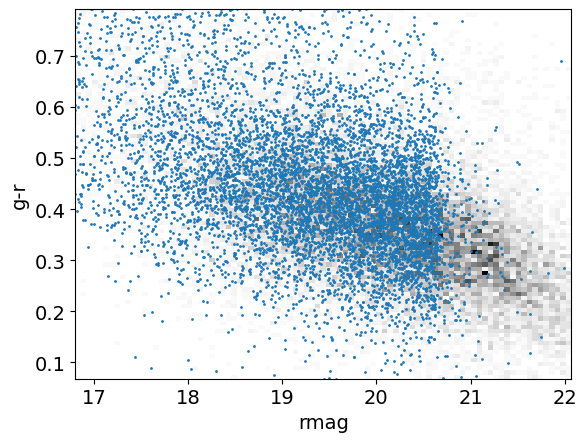

In [301]:
apercorr = merian_sources['i_cModelFlux_Merian']/merian_sources['i_gaap1p0Flux_Merian']
flux = merian_sources.loc[:,utils.photcols['r']]*apercorr
gr = -2.5*np.log10(merian_sources[utils.photcols['g']]/merian_sources[utils.photcols['r']]) + gecorr[:,0] - gecorr[:,1]
merian_rmag = -2.5*np.log10(flux) + 31.4

_=ek.hist2d(
    merian_rmag,
    gr,
    bins=90, 
)
plt.scatter(
    ref[3],
    ref[2]-ref[3],
    s=1,
)
#plt.xlim(7., 11.2)
plt.xlabel('rmag')
plt.ylabel('g-r')

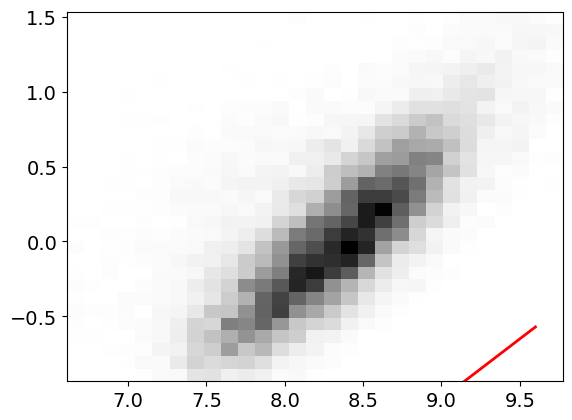

In [184]:
_=ek.hist2d(
    merian_sources['logmass_gaap1p0'],
    #merian_sources['logsfr_gaap1p0'],
    #np.log10(calibrations.LHa2SFR(lha_df['LHa']*1e40)),
    np.log10(calibrations.LUV2SFR_K98(catalog_halum['LFUV'])*0.66),
    bins=30
)
ms = np.linspace(7., 9.6, 10)
plt.plot(
    ms,
    0.8*(ms-8.5) - 1.45,
    color='r',
    lw=2
)

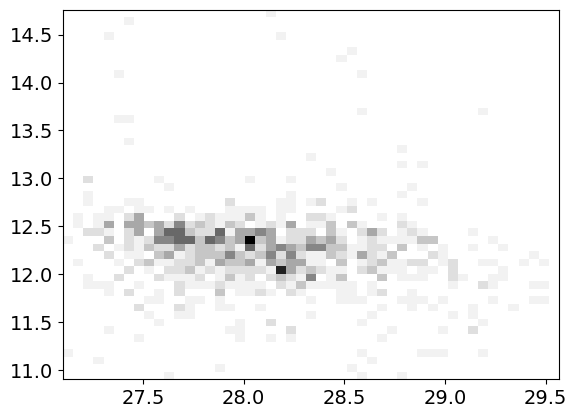

In [163]:
_=ek.hist2d(
    np.log10(catalog_halum.reindex(lha_df.index)['LFUV']),
    np.log10(lha_df['LHa']*1e40 / catalog_halum.reindex(lha_df.index)['LFUV']),
    bins=50
)